In [13]:
#Загрузка даных:
from sklearn.datasets import fetch_20newsgroups
categories = ["comp.graphics","sci.space","rec.sport.baseball"]
df = fetch_20newsgroups(subset='train', categories=categories)
df1 = fetch_20newsgroups(subset='test', categories=categories)

In [14]:
#Функция чистки текста:
import pymorphy2
import re

def clean_text(text):
    morph = pymorphy2.MorphAnalyzer()
    text = text.replace("\\", " ").replace(u"╚", " ").replace(u"╩", " ")
    text = text.lower()
    text = re.sub('\-\s\r\n\s{1,}|\-\s\r\n|\r\n', '', text) #удаление новых сстрок
    text = re.sub('[.,:;_%©?*,!@#$%^&()\d]|[+=]|[[]|[]]|[/]|"|\s{2,}|-', ' ', text) #удаление символов  
    text = ' '.join(word for word in text.split() if len(word)>3)
    text = " ".join(morph.parse(word)[0].normal_form for word in text.split())
    
    return text

In [15]:
#Чистка текста и нахождение макс длины текста(или обрезание):
k=0
m=0
# Максимальное количество слов в самом длинном описании заявки
max_words = 0
for text in df.data:
    text=clean_text(text)
    df.data[k]=text
    words = len(text.split())
    if words > 500:
        df.data[k]=text[:500]
        words=500
    if words > max_words:
        max_words = words
    k+=1

print('Максимальное количество слов в самом длинном описании заявки: {} слов'.format(max_words))

Максимальное количество слов в самом длинном описании заявки: 500 слов


In [16]:
#Составление словаря
#import pandas as pd
import numpy as np
import tensorflow as tf
from collections import Counter
vocab = Counter()
for text in df.data:
    for word in text.split(' '):
        vocab[word.lower()]=1
        
total_words = len(vocab)
print('Всего слов в словаре: ', total_words)

#Функция, которая возвращает индекс слова в словаре
def get_word_2_index(vocab):
    word2index = {}
    for i,word in enumerate(vocab):
        word2index[word.lower()] = i
        
    return word2index

word2index = get_word_2_index(vocab)

#Составление числовых векторов
batches = []
results = []
texts = df.data

for text in texts:
   k=0
   layer = np.zeros(max_words,dtype=float)
   for word in text.split(' '):
        if (vocab[word.lower()])!=0:
          layer[k] = word2index[word.lower()]
          k+=1
            
   batches.append(layer)
X_train=np.array(batches)

#print(X_train[0],X_train.shape)

y=0
#Добавление 4 категории unknow 
num_classes=4
target=np.zeros(num_classes)
y_train=np.zeros((len(df.target),num_classes))
for у in range(len(df.target)):
    #print(y,'= ',df.target[y])
    
    y_train[y,df.target[y]+1]=1
    target[df.target[y]+1]+=1
    #print(y,'= ',y_train[y])
    y+=1    

print('Распределение по рубликам: ',target)

#print(y_train[0],y_train.shape)

Всего слов в словаре:  20702
Распределение по рубликам:  [  0. 584. 597. 593.]


In [39]:
#Подготова текстов, которые не участвовали в составлении словаря
texts = df1.data[0:10]
batches = []
results = []
for text in texts:
   k=0
   text=clean_text(text)
   words = len(text.split())
   if words > 500:
        text=text[:500]
        words=500
   layer = np.zeros(max_words,dtype=float)
   for word in text.split(' '):
        if (vocab[word.lower()])!=0:
          layer[k] = word2index[word.lower()]
          k+=1
            
   batches.append(layer)
X_t=np.array(batches)

print(len(X_t[1]))

y=0
num_classes=4
targ=np.zeros(num_classes)
y_t=np.zeros((len(df1.target[0:10]),num_classes))
for у in range(len(df1.target[0:10])):
    #print(y,'= ',df.target[y])
    
    y_t[y,df1.target[y]+1]=1
    targ[df1.target[y]+1]+=1
    #print(y,'= ',y_train[y])
    y+=1    

print('Распределение по рубликам: ',targ)


500
Распределение по рубликам:  [0. 3. 4. 3.]


In [20]:
#Разбиение на обучающую и тестовую выборку
n=300
l=len(df.target)
X_test=X_train[l-n:l+1] 
y_test=y_train[l-n:l+1]
y_train=y_train[0:l-n]
X_train=X_train[0:l-n]
print('Размерность обучающей выборки: ',X_train.shape)
print('Размерность тестовой выборки: ',X_test.shape)

Размерность обучающей выборки:  (1474, 500)
Размерность тестовой выборки:  (300, 500)


In [61]:

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, CuDNNLSTM
from keras.layers import Activation
from keras.layers import Dropout,Conv1D,MaxPooling1D

# максимальное количество слов для анализа
max_features = total_words

print(u'Собираем модель...')
model = Sequential()
embedding_vector_length = 32
#Слой для векторного представления слов
model.add(Embedding(total_words, embedding_vector_length, input_length=max_words))
#одномерная свертка 1 слоя
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
#oбъединения для временных данных 1 слоя
model.add(MaxPooling1D(pool_size=2))
#одномерная свертка 2слоя
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
#oбъединения для временных данных 2слоя
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=9, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=12, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=15, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.3))
model.add(keras.layers.Dropout(0.3))
model.add(Dense(num_classes, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
   
print(model.summary())

Собираем модель...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 500, 32)           662464    
_________________________________________________________________
conv1d_52 (Conv1D)           (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_50 (MaxPooling (None, 250, 32)           0         
_________________________________________________________________
conv1d_53 (Conv1D)           (None, 250, 32)           4128      
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 125, 32)           0         
_________________________________________________________________
conv1d_54 (Conv1D)           (None, 125, 32)           5152      
_________________________________________________________________
max_pooling1d_52 (MaxPooling (None, 62, 32)            0 

In [ ]:
#Симуляция текстов, которые не содержать ни одного слова в словаре (не относится ни к одной теме)
for j in range(100):
    r=random.randint(0, 1474)
    X_train[r]=np.zeros(500)
    y_train[r]=np.zeros(4)
    y_train[r][0]=1

In [62]:
import random
#Обучение модели
batch_size = 32
epochs = 10
j=0

print(u'Тренируем модель...')
history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(X_test, y_test))

Тренируем модель...
Train on 1474 samples, validate on 300 samples
Epoch 1/10
1474/1474 [==============================] - 9s 6ms/step - loss: 0.5702 - acc: 0.7427 - val_loss: 0.5021 - val_acc: 0.7500
Epoch 2/10
1474/1474 [==============================] - 4s 3ms/step - loss: 0.5174 - acc: 0.7498 - val_loss: 0.4727 - val_acc: 0.7575
Epoch 3/10
1474/1474 [==============================] - 4s 3ms/step - loss: 0.4203 - acc: 0.7916 - val_loss: 0.2896 - val_acc: 0.8258
Epoch 4/10
1474/1474 [==============================] - 4s 3ms/step - loss: 0.2875 - acc: 0.8474 - val_loss: 0.2395 - val_acc: 0.9117
Epoch 5/10
1474/1474 [==============================] - 4s 3ms/step - loss: 0.1628 - acc: 0.9459 - val_loss: 0.1573 - val_acc: 0.9500
Epoch 6/10
1474/1474 [==============================] - 4s 3ms/step - loss: 0.0456 - acc: 0.9929 - val_loss: 0.1688 - val_acc: 0.9467
Epoch 7/10
1474/1474 [==============================] - 4s 3ms/step - loss: 0.0237 - acc: 0.9959 - val_loss: 0.2245 - val_acc: 0.

In [ ]:
#Оценка модели
score = model.evaluate(X_test, y_test,
                       batch_size=batch_size, verbose=1)
print()
print(u'Оценка теста: {}'.format(score[0]))
print(u'Оценка точности модели: {}'.format(score[1]))

In [42]:
#Получение прогноза от модели
import numpy as np
#Симуляция текста, не относится ни к одной категории (случайно 20 слов)
X_t[5]=np.zeros(500)
j=0
for j in range(20):
    r=random.randint(0, maw_words)
    X_t[5][r]=random.randint(0, total_words)

prediction = model.predict(X_t)

j=0
for j in range(10):
    print("Текст № ",j+1)
    print('Правильная категория: ',np.argmax(y_t[j]))
    print("Определенная моделью категория: ",np.argmax(prediction[j]))

[[0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[1 0 1 0 1 2 2 0 1 2]
Текст №  1
Правильная категория:  2
Определенная моделью категория:  2
Текст №  2
Правильная категория:  1
Определенная моделью категория:  2
Текст №  3
Правильная категория:  2
Определенная моделью категория:  2
Текст №  4
Правильная категория:  1
Определенная моделью категория:  1
Текст №  5
Правильная категория:  2
Определенная моделью категория:  2
Текст №  6
Правильная категория:  3
Определенная моделью категория:  0
Текст №  7
Правильная категория:  3
Определенная моделью категория:  3
Текст №  8
Правильная категория:  1
Определенная моделью категория:  1
Текст №  9
Правильная категория:  2
Определенная моделью категория:  2
Текст №  10
Правильная категория:  3
Определенная моделью категория:  1


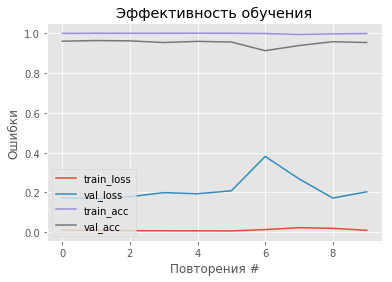

In [58]:
# Посмотрим на эффективность обучения
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Эффективность обучения")
plt.xlabel("Повторения #")
plt.ylabel("Ошибки")
plt.legend(loc="lower left")